<a href="https://colab.research.google.com/github/jdgargiulo/Lectures/blob/main/B_medio_y_H_cr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Algoritmo para cálculo automatizado de SIRM, B_1/2 y B_cr**

NOTA: El SIRM se calcula como el valor máximo de la magnetización obtenida sobre la curva completa de adquisición, independientemente del campo aplicado.

In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Cálculo de B 1/2

Partimos teniendo un data frame con una primera columna que con el campo aplicado en mT y las suscecibas representando la adquisicción en mA/m con nombre de columna correspondiente al nombre dado a cada muestra, en formato de archivo tipo .csv. Este archivo se importa en R con el nombre irm (automáticamente)

In [3]:
irm<-read.csv("/content/irm.csv", dec = ",")

In [4]:
campo<-irm %>% select(1)
irm<- irm %>% select(-1)
colnames(irm) <- paste0("m", 1:ncol(irm))
irm<-cbind(campo,irm)

In [5]:
View(irm)

Field,m1,m2,m3,m4,m5
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10,0.2947595,0.2947595,0.2947595,0.2947595,0.2947595
15,0.5620146,0.5620146,0.5620146,0.5620146,0.5620146
21,0.9945081,0.9945081,0.9945081,0.9945081,0.9945081
25,1.2563035,1.2563035,1.2563035,1.2563035,1.2563035
29,1.5324674,1.5324674,1.5324674,1.5324674,1.5324674
36,1.7784561,1.7784561,1.7784561,1.7784561,1.7784561
41,1.9365107,1.9365107,1.9365107,1.9365107,1.9365107
49,2.1664076,2.1664076,2.1664076,2.1664076,2.1664076
60,2.2985984,2.2985984,2.2985984,2.2985984,2.2985984


Se genera un primer gráfico de adquisición vs log(campo) con la intersección en Y sobre la SIRM/2. Se toma el valor de SIRM como el máximo encontrado en la curva.

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


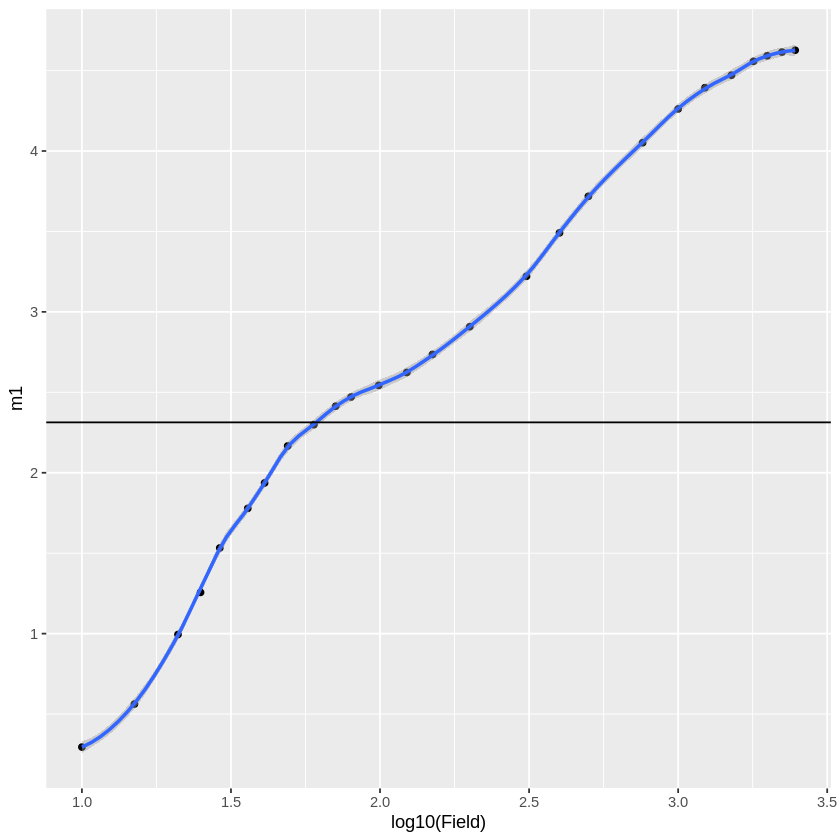

In [6]:
irm %>% ggplot(aes(x=log10(Field), y=m1)) +
  geom_point() +
  geom_smooth(span=0.2)+
  geom_hline(yintercept = max(irm$m1)/2)



El segundo gráfico es igual al primero pero invertido en los ejes la adquisición sobre el eje X, y el log(campo) en el eje Y

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


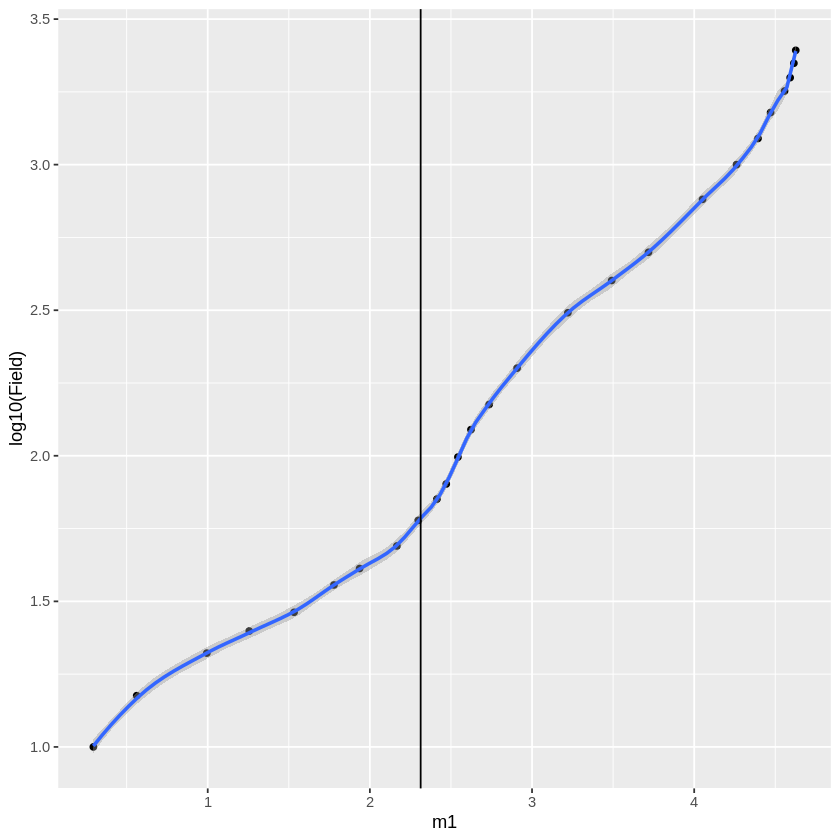

In [7]:
irm %>% ggplot(aes(y=log10(Field), x=m1)) +
  geom_point() +
  geom_smooth(span=0.2)+
  geom_vline(xintercept = 0.5*max(irm$m1))

In [8]:
adq<-irm %>% select(-Field)

Se ajusta una fuanción de suavizado loess (regresión local polinómica) donde de la variable de respuesta es el campo aplicado, y la regresora es la magnetización adquirida.

In [9]:
loess.filter <- function(x, y, span) {
  loess_fit <- loess(y ~ x, span = span)
  return(loess_fit)
}

Aplicamos la función loess.filter a cada columna del DF adq

In [10]:
suavizado <- lapply(adq, loess.filter, y = log10(irm$Field), span = 0.2)

Evaluamos la función en cada SIRM/2 para hallar los B1/2

In [11]:
predictions <- lapply(suavizado, function(loess_fit) {
  predict(loess_fit, newdata = data.frame(x = 0.5*(apply(adq, 2, max))))})

Construye un nuevo DF con nombre de muestra, SIRM, SIRM/2 y B1/2

In [12]:
for (i in ncol(irm)) {
  SIRM<-
    data.frame(muestra=colnames(irm[2:ncol(irm)]),
               SIRM=max(irm[i]),
               SIRM_2=max(irm[i])/2,
               B_medio=10**predictions[[1]])
}

In [13]:
View(SIRM)

,muestra,SIRM,SIRM_2,B_medio
,<chr>,<dbl>,<dbl>,<dbl>
m1,m1,4.626305,2.313152,61.02617
m2,m2,4.626305,2.313152,61.02617
m3,m3,4.626305,2.313152,61.02617
m4,m4,4.626305,2.313152,61.02617
m5,m5,4.626305,2.313152,61.02617


# Calculo de H_cr

El DF debe de tener el campo en primera columna, y las columnas siguientes serán las magnetizaciones en campo reverso para cada columna.

In [14]:
campo<-backfield %>% select(1)
back<- backfield %>% select(-1)
colnames(back) <- paste0("m", 1:ncol(backfield))
backfield<-cbind(campo,back)

ERROR: ignored

In [ ]:
backfield %>% ggplot(aes(x=log10(Field), y=m1)) +
  geom_point() +
  geom_smooth(span=0.2)

In [ ]:
back<-backfield %>% select(-Field)

In [ ]:
suavizadoB <- lapply(back, loess.filter, y = log10(backfield$Field), span = 0.2)

In [ ]:
predictionsB <- lapply(suavizadoB, function(loess_fit) {
  predict(loess_fit, newdata = data.frame(x = 0))})


In [ ]:
for (i in ncol(irm)) {
  SIRM<-
    data.frame(muestra=colnames(irm[2:ncol(irm)]),
               SIRM=max(irm[i]),
               SIRM_2=max(irm[i])/2,
               B_medio=10**predictions[[1]],
               Hcr=predictionsB)
}
